In [1]:
import http.client
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder

conn = http.client.HTTPSConnection("v3.football.api-sports.io")

headers = {
    'x-rapidapi-host': "v3.football.api-sports.io",
    'x-rapidapi-key': "5cf553b6b73d7130cdb6bc81975c2510"
}

# this function takes a seson and league id
# returns fixture data for that league in given season
# NOTE premier league id is 39
def get_fixtures(season, league_id):
    params = f"/fixtures?season={season}&league={league_id}"
    conn.request("GET", params, headers=headers)
    response = conn.getresponse()
    data = response.read()
    data_json = json.loads(data.decode("utf-8"))

    return data_json


# this function takes a league_id, team_id, season and date
# gets the season stats for said team
# will be used with get_fixtures (which has the team_id) to get lots of fixtures results and then the stats of the teams on season
# we need to have the date parameter because we need stats up to the point of a game for accurate training set data
# then we can make predictions based on the observed results and season statistics
def get_stats(league_id, team_id, season, date):
    params = f"/teams/statistics?season={season}&team={team_id}&league={league_id}&date={date}"

    conn.request("GET", params, headers=headers)
    response = conn.getresponse()
    data = response.read()
    data_json = json.loads(data.decode("utf-8"))

    return data_json

In [2]:
# we have the necessary functions to get the data needed, now we will begin getting data and starting the analysis
all_fixtures = []

fixtures = get_fixtures(2022, 39)

for fixture in fixtures['response']:
        match_data = {  
            'date': fixture['fixture']['date'].split("T")[0],
            'home': fixture['teams']['home']['name'],
            'away': fixture['teams']['away']['name'],
            'score_home': fixture['score']['fulltime']['home'],
            'score_away': fixture['score']['fulltime']['away'],
        }

        all_fixtures.append(match_data)
        
fixtures_df = pd.DataFrame(all_fixtures)

In [6]:
# adding streak data
fixtures_df['home_streak'] = 0
fixtures_df['away_streak'] = 0

streak = {i: 0 for i in range(20)}

# Use sklearn to encode the team names (categorical) to numerical values for prediction
label_encoder = LabelEncoder()
fixtures_df['home_team_encoded'] = label_encoder.fit_transform(fixtures_df['home'])
fixtures_df['away_team_encoded'] = label_encoder.fit_transform(fixtures_df['away'])

for index, row in fixtures_df.iterrows():
    home_team = row['home_team_encoded']
    away_team = row['away_team_encoded']

    home_score = int(row['score_home']) if isinstance(row['score_home'], (int, float)) else row['score_home'].item()
    away_score = int(row['score_away']) if isinstance(row['score_away'], (int, float)) else row['score_away'].item()

    if home_score > away_score:
        home_result = 1
        away_result = -1
    elif home_score < away_score:
        home_result = -1
        away_result = 1
    else:
        home_result = 0
        away_result = 0

    fixtures_df.at[index, 'home_streak'] = streak[home_team]
    fixtures_df.at[index, 'away_streak'] = streak[away_team]

    # if not in streak they have not played yet
    # they should already be in there but this is for safety
    if home_team not in streak:
        streak[home_team] = 0
    # they have played
    else:
        if streak[home_team] > 0: # on a win streak
            if home_result: # they win
                streak[home_team] += 1
            else: # they draw or lose
                streak[home_team] = 0
        elif streak[home_team] < 0: # on a lose streak
            if not home_result: # they lose
                streak[home_team] -= 1
            else: # they draw or win
                streak[home_team] = 0
        else: # they have no streak
            streak[home_team] += home_result

    # same thing for away team    
    if away_team not in streak:
        streak[away_team] = 0
    else:
        if streak[away_team] > 0:
            if away_result:
                streak[away_team] += 1
            else:
                streak[away_team] = 0
        elif streak[away_team] < 0:
            if not away_result:
                streak[away_team] -= 1
            else:
                streak[away_team] = 0
        else:
            streak[away_team] += away_result

# Adding result attribute 1 for home win, -1 for away win, and 0 for draw
fixtures_df['result'] = (fixtures_df['score_home'] > fixtures_df['score_away']).astype(int) - (fixtures_df['score_home'] < fixtures_df['score_away']).astype(int)

fixtures_df.to_csv('fixtures_2022.csv', index=False)

C:\Users\benja\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benja\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benja\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benja\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

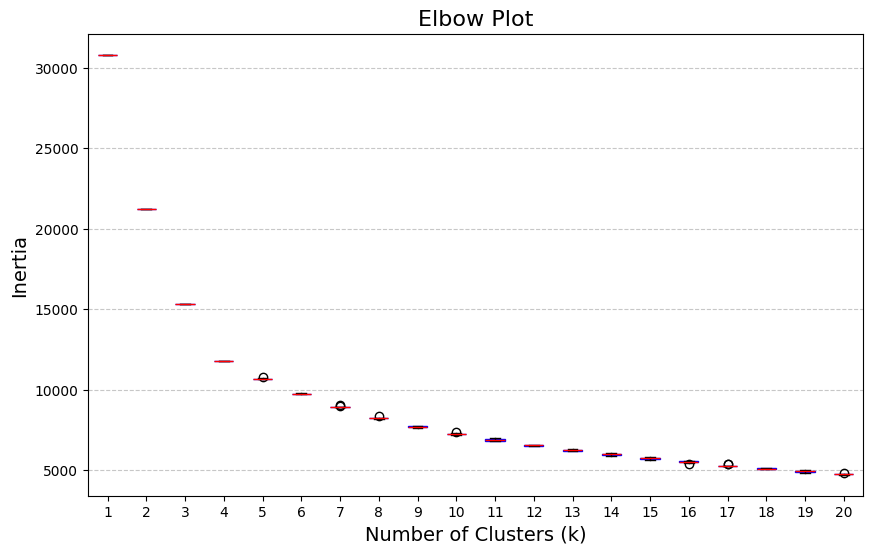

In [22]:
# getting data from the written csv file
import matplotlib.pyplot as plt
from sklearn import cluster

preproc_df = pd.read_csv('fixtures_2022.csv')

X, y = preproc_df[['home_streak', 'away_streak', 'home_team_encoded', 'away_team_encoded']], preproc_df['result']

# finding optimal K
k_values = range(1, 21)
runs = 10
performance = {k: [] for k in k_values}

for k in k_values:
    for _ in range(runs):
        kmeans = cluster.KMeans(n_clusters=k, init="random")
        kmeans.fit(X)
        performance[k].append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.boxplot(
    [performance[k] for k in k_values],
    labels=k_values,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red"),
)
plt.title("Elbow Plot", fontsize=16)
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# from elbow plot around 4 clusters will be best



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


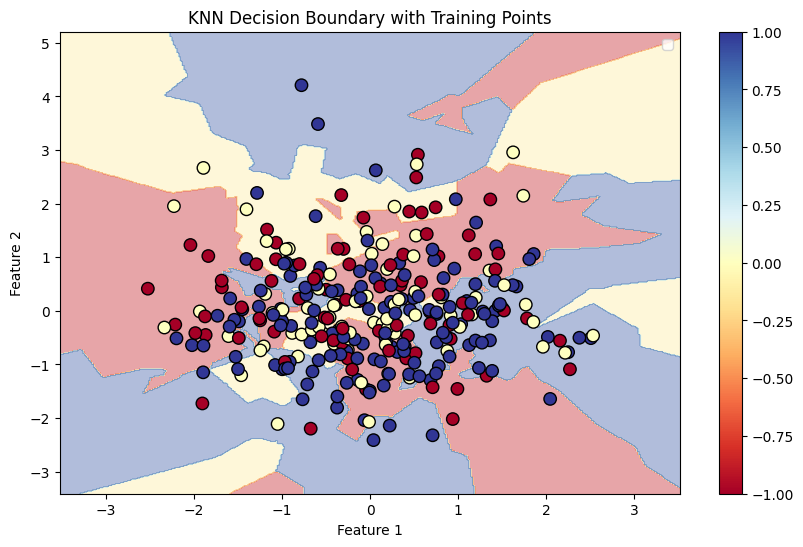

In [ ]:
# applying k-nn with 4 clusters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

y_predictions = knn.predict(X_test)

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

h = .02 
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = knn.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='k', s=80)
plt.title("KNN Decision Boundary with Training Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter)

plt.legend()
plt.show()



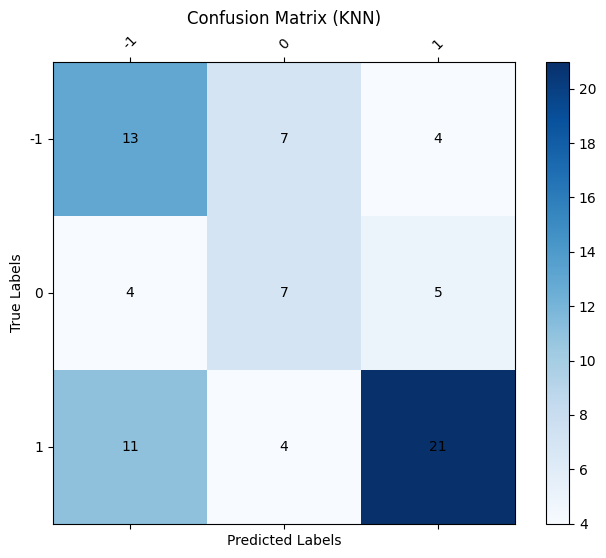

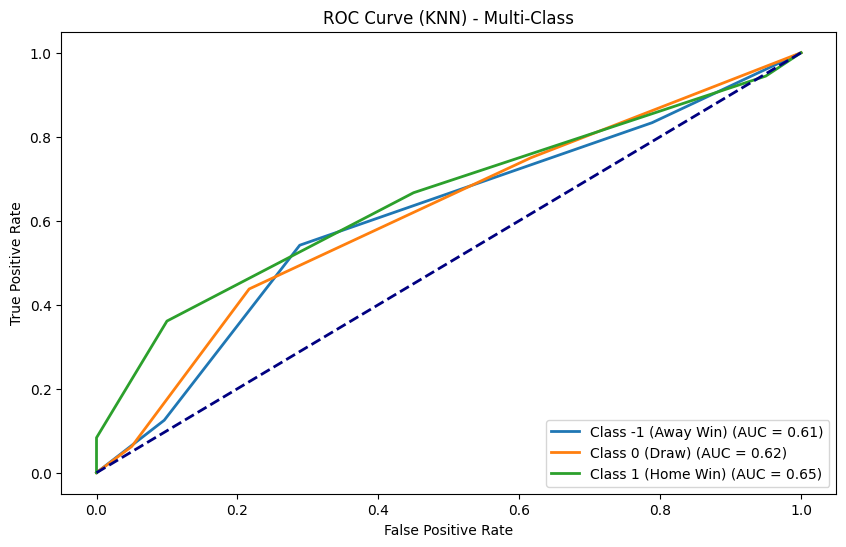

In [24]:
# analysis of results (for knn)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

cm = confusion_matrix(y_test, y_predictions)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap="Blues")

# Add color bar
fig.colorbar(cax)

# Add labels
ax.set_xticks(np.arange(len(np.unique(y_test))))
ax.set_yticks(np.arange(len(np.unique(y_test))))
ax.set_xticklabels(np.unique(y_test))
ax.set_yticklabels(np.unique(y_test))

# Rotate the labels for better visibility
plt.xticks(rotation=45)

# Add axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Annotate matrix cells with the numeric value
for i in range(len(np.unique(y_test))):
    for j in range(len(np.unique(y_test))):
        ax.text(j, i, cm[i, j], ha='center', va='center', color="black")

plt.title("Confusion Matrix (KNN)")
plt.show()

# this is the plot for the confusion matrix which is a big part of our results
# the accuracy may not look amazing in this but for the context of sports betting the results are actually very good because of the line that all sports books offer
# this line is the 1X or 2X line where 1X means either home team wins or game ends in draw and the same for the 2X bet (read more on this if needed)
# but this means if a home win or away win is predicted and you take the 1X or 2X bet then the win percentage is actually very good
# other things to note is we are more successful at predicting home team wins rather than away team wins (potentially harder to predict)


# ROC curve below
lb = LabelBinarizer()
y_bin = lb.fit_transform(y_test)
y_probs = knn.predict_proba(X_test)

n_classes = y_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Plot ROC for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    if lb.classes_[i] == 1:
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (Home Win) (AUC = {roc_auc[i]:.2f})')
    elif lb.classes_[i] == -1:
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (Away Win) (AUC = {roc_auc[i]:.2f})')
    else: 
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (Draw) (AUC = {roc_auc[i]:.2f})')

# Plot the ROC curve for all classes
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


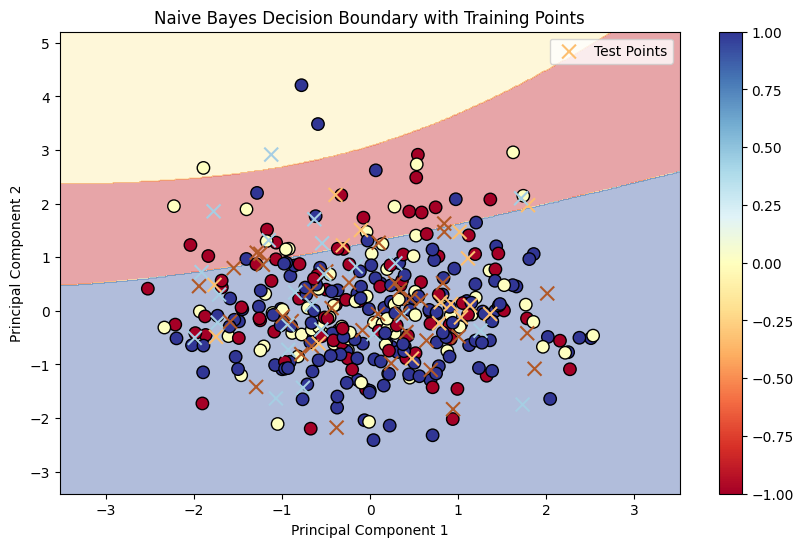

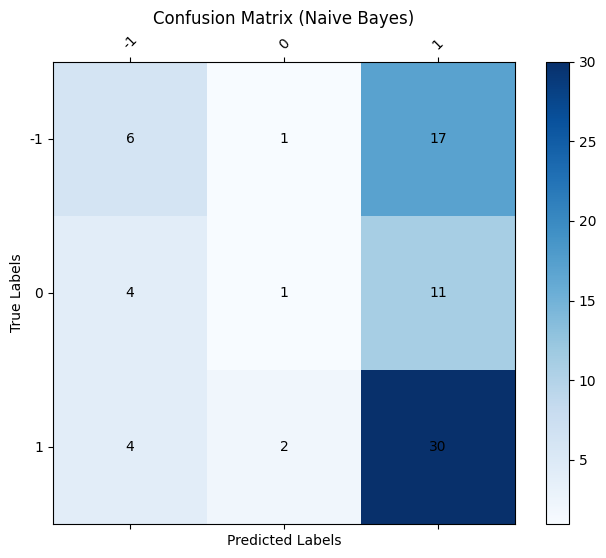

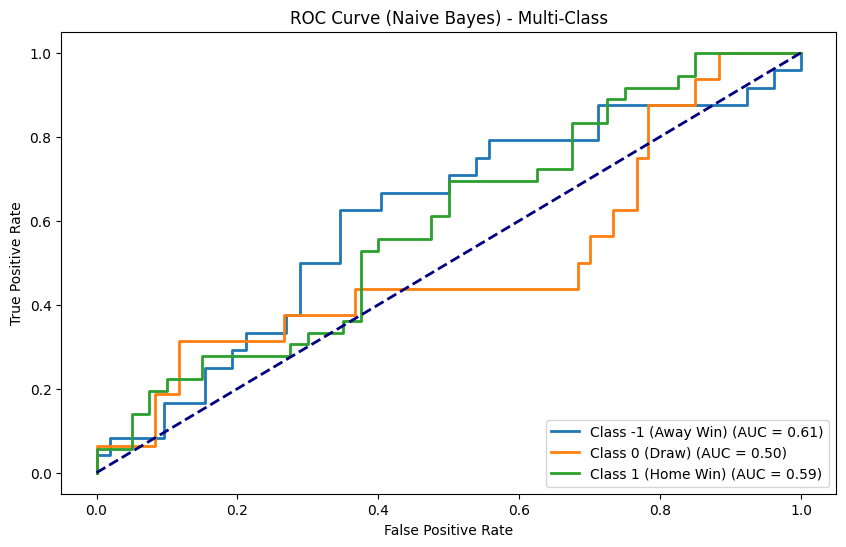

In [28]:
# Naive Bayes Predictions
from sklearn.naive_bayes import GaussianNB

nb_prediction = GaussianNB()

nb_prediction.fit(X_train, y_train)

y_predictions_NB = nb_prediction.predict(X_test)

# Create a meshgrid to plot decision boundaries
h = .02  # Step size
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict class labels for each point in the meshgrid
Z = nb_prediction.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

# Plot the training points
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='k', s=80)
plt.title("Naive Bayes Decision Boundary with Training Points")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter)

# Plot the test points
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.Paired, marker='x', s=100, label="Test Points")

# Add a legend and show the plot
plt.legend()
plt.show()

cm_NB = confusion_matrix(y_test, y_predictions_NB)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm_NB, cmap="Blues")

# Add color bar
fig.colorbar(cax)

# Add labels
ax.set_xticks(np.arange(len(np.unique(y_test))))
ax.set_yticks(np.arange(len(np.unique(y_test))))
ax.set_xticklabels(np.unique(y_test))
ax.set_yticklabels(np.unique(y_test))

# Rotate the labels for better visibility
plt.xticks(rotation=45)

# Add axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Annotate matrix cells with the numeric value
for i in range(len(np.unique(y_test))):
    for j in range(len(np.unique(y_test))):
        ax.text(j, i, cm_NB[i, j], ha='center', va='center', color="black")

plt.title("Confusion Matrix (Naive Bayes)")
plt.show()

# ROC Curve Below
y_probs_NB = nb_prediction.predict_proba(X_test)

n_classes = y_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Plot ROC for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs_NB[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    if lb.classes_[i] == 1:
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (Home Win) (AUC = {roc_auc[i]:.2f})')
    elif lb.classes_[i] == -1:
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (Away Win) (AUC = {roc_auc[i]:.2f})')
    else: 
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (Draw) (AUC = {roc_auc[i]:.2f})')

# Plot the ROC curve for all classes
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes) - Multi-Class')
plt.legend(loc="lower right")
plt.show()
